In [23]:
#code implemented from this article
# url : https://nextjournal.com/gkoehler/pytorch-mnist

##TODO:
##AJOUTER DES COMMENTAIRES DÉTAILÉS POUR MIEUX COMPRENDRE LE FONCTIONNEMENT
##VOIR COMMENT TU PEUX TRANSFORMER ÇA EN SCRIPT
##ENLEVER CELLS INUTILE AU PROJET
##AJOUTER CHECK POUR GPU
##RENDRE PLUS DYNAMIQUE AU NIVEAU DES PATHS

import torch
import torchvision

In [24]:
#define hyperparameters
n_epochs = 3
batch_size_train = 64
batch_size_test = 1000
learning_rate = 0.01
momentum = 0.5
log_interval = 10

#define random seed manualy for a repeatable experiment
random_seed = 1
torch.backends.cudnn.enabled = False #disable nondeterministics algorithms used by cuDNN
torch.manual_seed(random_seed)

In [25]:
#he values 0.1307 and 0.3081 used for the Normalize() transformation below are the global mean and standard deviation of the MNIST dataset

#créer un classe qui extend datasets pour nos données
#loader ficher csv 

train_loader = torch.utils.data.DataLoader(torchvision.datasets.MNIST("", train = True, download = True,
                                          transform = torchvision.transforms.Compose([
                                              torchvision.transforms.ToTensor(),
                                              torchvision.transforms.Normalize(
                                              (0.1307,),(0.3081,))
                                          ])), batch_size = batch_size_train, shuffle = True)

test_loader = torch.utils.data.DataLoader(torchvision.datasets.MNIST("",train = False, download = True,
                                                                    transform = torchvision.transforms.Compose([
                                                                                torchvision.transforms.ToTensor(),
                                                                                torchvision.transforms.Normalize(
                                                                                                                 (0.1307,),(0.3081,))
                                                                    ])), batch_size = batch_size_test, shuffle = True)

                                          

shape : torch.Size([1000, 1, 28, 28])


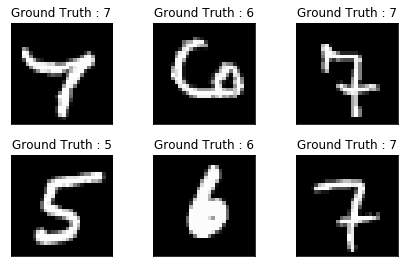

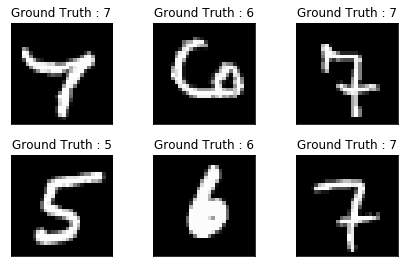

In [26]:
#load examples to confirm data is ok

examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)

#shape should be [1000,1,28,28]
print("shape :", example_data.shape)


#display some images contained in the test examples
import matplotlib.pyplot as plt

fig = plt.figure() #create a new figure

for i in range(6):
    plt.subplot(2,3,i+1) #add subplots to the figure (nrows, ncols, index)
    plt.tight_layout() #automatically adjusts subplot params so that the subplot(s) fits in to the figure area
    plt.imshow(example_data[i][0], cmap='gray',interpolation = 'none') #Display data as an image
    plt.title("Ground Truth : {}".format(example_targets[i])) #Set a title for the axes
    #set empty ticks to remove them
    plt.xticks([])
    plt.yticks([])
fig 

In [27]:
#building the network
##COMMENTER ÉTAPE ICI

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1,10,kernel_size=5)
        self.conv2 = nn.Conv2d(10,20,kernel_size=5)
        self.conv2_drop = nn.Dropout2d() 
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10 ) 
    
    #method that compute the data through the defined layers
    def forward(self,x):
        x = F.relu(F.max_pool2d(self.conv1(x),2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)),2))
        x = x.view(-1,320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training = self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim = 1)

In [28]:
#initialize the network and optimizer

###If we were using a GPU for training, we should have also sent the network parameters to the GPU using e.g. network.cuda(). It is important to transfer the network's parameters to the appropriate device before passing them to the optimizer, otherwise the optimizer will not be able to keep track of them in the right way.

network = Net()
optimizer = optim.SGD(network.parameters(),lr = learning_rate, momentum = momentum)

In [29]:
train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]

In [30]:
##COMMENTER LES ÉTAPES ICI
def train(epoch):
    network.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = network(data)
        loss = F.nll_loss(output,target)
        loss.backward()
        optimizer.step()
        
        if batch_idx % log_interval == 0 :
            print('Train Epoch : {} [{}/{} ({:.0f}%)]\tLoss:{:.6f}'
                  .format(epoch,batch_idx * len(data), len(train_loader.dataset),
                          100. * batch_idx / len(train_loader), loss.item()))
            train_losses.append(loss.item())
            train_counter.append((batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))
            #changer output path pour lib 
            torch.save(network.state_dict() , "/Users/etiennemontenegro/Desktop/MNIST_CLASSIFIER/results/model.pth")
            torch.save(optimizer.state_dict(), "/Users/etiennemontenegro/Desktop/MNIST_CLASSIFIER/results/optimizer.pth")
            
            

In [31]:
def test():
  network.eval()
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for data, target in test_loader:
      #print(data)
      output = network(data)
      test_loss += F.nll_loss(output, target, size_average=False).item()
      pred = output.data.max(1, keepdim=True)[1]
      correct += pred.eq(target.data.view_as(pred)).sum()
  test_loss /= len(test_loader.dataset)
  test_losses.append(test_loss)
  print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))

In [32]:

#test model before training
test()

#training loop
for epoch in range(1, n_epochs +1):
    train(epoch)
    test()


Test set: Avg. loss: 2.3004, Accuracy: 751/10000 (8%)

Train Epoch : 1 [0/60000 (0%)]	Loss:2.268458
Train Epoch : 1 [640/60000 (1%)]	Loss:2.268337
Train Epoch : 1 [1280/60000 (2%)]	Loss:2.273999
Train Epoch : 1 [1920/60000 (3%)]	Loss:2.251667
Train Epoch : 1 [2560/60000 (4%)]	Loss:2.236732
Train Epoch : 1 [3200/60000 (5%)]	Loss:2.223633
Train Epoch : 1 [3840/60000 (6%)]	Loss:2.152995
Train Epoch : 1 [4480/60000 (7%)]	Loss:2.095961
Train Epoch : 1 [5120/60000 (9%)]	Loss:1.974665
Train Epoch : 1 [5760/60000 (10%)]	Loss:1.946313
Train Epoch : 1 [6400/60000 (11%)]	Loss:1.841838
Train Epoch : 1 [7040/60000 (12%)]	Loss:1.768894
Train Epoch : 1 [7680/60000 (13%)]	Loss:1.699719
Train Epoch : 1 [8320/60000 (14%)]	Loss:1.687801
Train Epoch : 1 [8960/60000 (15%)]	Loss:1.507811
Train Epoch : 1 [9600/60000 (16%)]	Loss:1.388498
Train Epoch : 1 [10240/60000 (17%)]	Loss:1.293032
Train Epoch : 1 [10880/60000 (18%)]	Loss:1.319806
Train Epoch : 1 [11520/60000 (19%)]	Loss:1.284501
Train Epoch : 1 [12160/

Train Epoch : 2 [44160/60000 (74%)]	Loss:0.388296
Train Epoch : 2 [44800/60000 (75%)]	Loss:0.457454
Train Epoch : 2 [45440/60000 (76%)]	Loss:0.447066
Train Epoch : 2 [46080/60000 (77%)]	Loss:0.416286
Train Epoch : 2 [46720/60000 (78%)]	Loss:0.271391
Train Epoch : 2 [47360/60000 (79%)]	Loss:0.279079
Train Epoch : 2 [48000/60000 (80%)]	Loss:0.506901
Train Epoch : 2 [48640/60000 (81%)]	Loss:0.346770
Train Epoch : 2 [49280/60000 (82%)]	Loss:0.371337
Train Epoch : 2 [49920/60000 (83%)]	Loss:0.311098
Train Epoch : 2 [50560/60000 (84%)]	Loss:0.292245
Train Epoch : 2 [51200/60000 (85%)]	Loss:0.445767
Train Epoch : 2 [51840/60000 (86%)]	Loss:0.191965
Train Epoch : 2 [52480/60000 (87%)]	Loss:0.422921
Train Epoch : 2 [53120/60000 (88%)]	Loss:0.396854
Train Epoch : 2 [53760/60000 (90%)]	Loss:0.297356
Train Epoch : 2 [54400/60000 (91%)]	Loss:0.312771
Train Epoch : 2 [55040/60000 (92%)]	Loss:0.351085
Train Epoch : 2 [55680/60000 (93%)]	Loss:0.663257
Train Epoch : 2 [56320/60000 (94%)]	Loss:0.340837


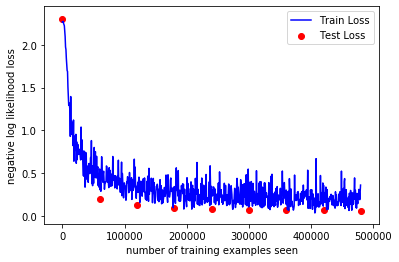

In [48]:
#peut devenir une fonction parce que réutiliser plus bas
def plotLoss():
    fig = plt.figure()
    plt.plot(train_counter , train_losses, color = 'blue')
    plt.scatter(test_counter, test_losses, color = 'red')
    plt.legend(['Train Loss' , 'Test Loss'],loc='upper right')
    plt.xlabel('number of training examples seen')
    plt.ylabel('negative log likelihood loss')
    fig
    
plotLoss()

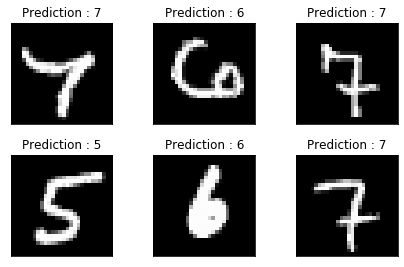

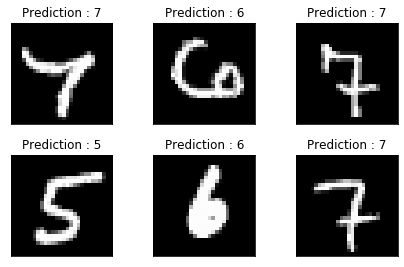

In [35]:
#look at a few examples as we did earlier and compare the model's output.

with torch.no_grad():
    output = network(example_data)

fig = plt.figure() #create a new figure

for i in range(6):
    plt.subplot(2,3,i+1) #add subplots to the figure (nrows, ncols, index)
    plt.tight_layout() #automatically adjusts subplot params so that the subplot(s) fits in to the figure area
    plt.imshow(example_data[i][0], cmap='gray',interpolation = 'none') #Display data as an image
    plt.title("Prediction : {}".format(output.data.max(1,keepdim=True)[1][i].item())) #Set a title for the axes
    #set empty ticks to remove them
    plt.xticks([])
    plt.yticks([])
fig 

In [36]:
### steps to continue to train a model from exported state_dicts

#initialize a new set of network and optimizers
continued_network = Net()
continued_optimizer = optim.SGD(network.parameters(), lr = learning_rate, momentum = momentum)

In [44]:

network_state_dict = torch.load("/Users/etiennemontenegro/Desktop/MNIST_CLASSIFIER/results/model.pth")
continued_network.load_state_dict(network_state_dict)

optimizer_state_dict = torch.load("/Users/etiennemontenegro/Desktop/MNIST_CLASSIFIER/results/optimizer.pth")
continued_optimizer.load_state_dict(optimizer_state_dict)
    
                                

In [45]:
for i in range(4,9):
    # Due to the way we constructed the test counter for the number of training examples seen we manually have to append to it here.
    test_counter.append(i*len(train_loader.dataset))
    train(i)
    test()

Train Epoch : 4 [0/60000 (0%)]	Loss:0.342203
Train Epoch : 4 [640/60000 (1%)]	Loss:0.300529
Train Epoch : 4 [1280/60000 (2%)]	Loss:0.176704
Train Epoch : 4 [1920/60000 (3%)]	Loss:0.145587
Train Epoch : 4 [2560/60000 (4%)]	Loss:0.379472
Train Epoch : 4 [3200/60000 (5%)]	Loss:0.561322
Train Epoch : 4 [3840/60000 (6%)]	Loss:0.310572
Train Epoch : 4 [4480/60000 (7%)]	Loss:0.296270
Train Epoch : 4 [5120/60000 (9%)]	Loss:0.330862
Train Epoch : 4 [5760/60000 (10%)]	Loss:0.232940
Train Epoch : 4 [6400/60000 (11%)]	Loss:0.529520
Train Epoch : 4 [7040/60000 (12%)]	Loss:0.177150
Train Epoch : 4 [7680/60000 (13%)]	Loss:0.257163
Train Epoch : 4 [8320/60000 (14%)]	Loss:0.173365
Train Epoch : 4 [8960/60000 (15%)]	Loss:0.300631
Train Epoch : 4 [9600/60000 (16%)]	Loss:0.171042
Train Epoch : 4 [10240/60000 (17%)]	Loss:0.176530
Train Epoch : 4 [10880/60000 (18%)]	Loss:0.244425
Train Epoch : 4 [11520/60000 (19%)]	Loss:0.353992
Train Epoch : 4 [12160/60000 (20%)]	Loss:0.294688
Train Epoch : 4 [12800/60000 

/Users/etiennemontenegro/opt/miniconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.0816, Accuracy: 9750/10000 (98%)

Train Epoch : 5 [0/60000 (0%)]	Loss:0.344233
Train Epoch : 5 [640/60000 (1%)]	Loss:0.229798
Train Epoch : 5 [1280/60000 (2%)]	Loss:0.298382
Train Epoch : 5 [1920/60000 (3%)]	Loss:0.266681
Train Epoch : 5 [2560/60000 (4%)]	Loss:0.242569
Train Epoch : 5 [3200/60000 (5%)]	Loss:0.338486
Train Epoch : 5 [3840/60000 (6%)]	Loss:0.294691
Train Epoch : 5 [4480/60000 (7%)]	Loss:0.154039
Train Epoch : 5 [5120/60000 (9%)]	Loss:0.254404
Train Epoch : 5 [5760/60000 (10%)]	Loss:0.313282
Train Epoch : 5 [6400/60000 (11%)]	Loss:0.135229
Train Epoch : 5 [7040/60000 (12%)]	Loss:0.238467
Train Epoch : 5 [7680/60000 (13%)]	Loss:0.180455
Train Epoch : 5 [8320/60000 (14%)]	Loss:0.254052
Train Epoch : 5 [8960/60000 (15%)]	Loss:0.177650
Train Epoch : 5 [9600/60000 (16%)]	Loss:0.231439
Train Epoch : 5 [10240/60000 (17%)]	Loss:0.247963
Train Epoch : 5 [10880/60000 (18%)]	Loss:0.384209
Train Epoch : 5 [11520/60000 (19%)]	Loss:0.129162
Train Epoch : 5 [1216

Train Epoch : 6 [44160/60000 (74%)]	Loss:0.274028
Train Epoch : 6 [44800/60000 (75%)]	Loss:0.173552
Train Epoch : 6 [45440/60000 (76%)]	Loss:0.342149
Train Epoch : 6 [46080/60000 (77%)]	Loss:0.101076
Train Epoch : 6 [46720/60000 (78%)]	Loss:0.139329
Train Epoch : 6 [47360/60000 (79%)]	Loss:0.243516
Train Epoch : 6 [48000/60000 (80%)]	Loss:0.194436
Train Epoch : 6 [48640/60000 (81%)]	Loss:0.185543
Train Epoch : 6 [49280/60000 (82%)]	Loss:0.220218
Train Epoch : 6 [49920/60000 (83%)]	Loss:0.201649
Train Epoch : 6 [50560/60000 (84%)]	Loss:0.322282
Train Epoch : 6 [51200/60000 (85%)]	Loss:0.128130
Train Epoch : 6 [51840/60000 (86%)]	Loss:0.165617
Train Epoch : 6 [52480/60000 (87%)]	Loss:0.278631
Train Epoch : 6 [53120/60000 (88%)]	Loss:0.254275
Train Epoch : 6 [53760/60000 (90%)]	Loss:0.524215
Train Epoch : 6 [54400/60000 (91%)]	Loss:0.274996
Train Epoch : 6 [55040/60000 (92%)]	Loss:0.148147
Train Epoch : 6 [55680/60000 (93%)]	Loss:0.209612
Train Epoch : 6 [56320/60000 (94%)]	Loss:0.207186


Train Epoch : 8 [28160/60000 (47%)]	Loss:0.120743
Train Epoch : 8 [28800/60000 (48%)]	Loss:0.523232
Train Epoch : 8 [29440/60000 (49%)]	Loss:0.199044
Train Epoch : 8 [30080/60000 (50%)]	Loss:0.156632
Train Epoch : 8 [30720/60000 (51%)]	Loss:0.177294
Train Epoch : 8 [31360/60000 (52%)]	Loss:0.185963
Train Epoch : 8 [32000/60000 (53%)]	Loss:0.321040
Train Epoch : 8 [32640/60000 (54%)]	Loss:0.110751
Train Epoch : 8 [33280/60000 (55%)]	Loss:0.399133
Train Epoch : 8 [33920/60000 (57%)]	Loss:0.435825
Train Epoch : 8 [34560/60000 (58%)]	Loss:0.084735
Train Epoch : 8 [35200/60000 (59%)]	Loss:0.288433
Train Epoch : 8 [35840/60000 (60%)]	Loss:0.137590
Train Epoch : 8 [36480/60000 (61%)]	Loss:0.305290
Train Epoch : 8 [37120/60000 (62%)]	Loss:0.190607
Train Epoch : 8 [37760/60000 (63%)]	Loss:0.120609
Train Epoch : 8 [38400/60000 (64%)]	Loss:0.192949
Train Epoch : 8 [39040/60000 (65%)]	Loss:0.101407
Train Epoch : 8 [39680/60000 (66%)]	Loss:0.208080
Train Epoch : 8 [40320/60000 (67%)]	Loss:0.220377


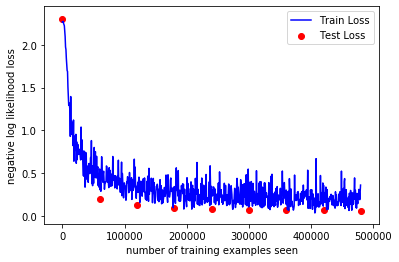

In [49]:
plotLoss()